In [121]:
import pandas as pd 
import json
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
df_final = pd.read_csv("data/lda/df_30topics10passes.csv")
final_topic_id = 19
final_threshold = 0.3 
# TODO!

if "uq_agenda" not in df_final.columns:
    df_final["uq_agenda"] = df_final["agenda"] + df_final["date"]

In [6]:
# sanity check: look at migration speech with highest score: 
df_final[df_final["topic_"+str(final_topic_id)] == (df_final["topic_"+str(final_topic_id)]).max()]["translatedText"].iloc[0]

'I voted in favour of this report. Europe has been paralysed with regard to the migrant crisis. While we keep discussing possible solutions to the grave problem we face, it hardly ever comes to common action. However, even when we do decide on joint measures, we do not follow through on them. The Dublin Agreement and the relocation system have failed utterly, as the Member States have not committed to apply them. We must either effectively enforce the current measures, or introduce new ones. Either way, it is not a problem that can be solved by any Member State alone. It is a dilemma that must be dealt with by the European Union as a whole. It cannot be fixed by closing national borders, but only by guarding our common ones; those defined by Schengen. What we need to do is form a common border guard and coast guard and put a collective reception and relocation system in place. Furthermore, we must prompt Turkey to crack down on the criminals smuggling refugees to Europe under harsh cir

In [46]:
df_migration_speeches = df_final[df_final[f"topic_{final_topic_id}"] >= final_threshold]
# full debates where at least one speech is migration related
df_migration_agendas = df_final[df_final["uq_agenda"].isin(df_migration_speeches["uq_agenda"])]

In [ ]:
def print_agendas(agenda_items, first_k=3):
    df = df_final[df_final["uq_agenda"].isin(agenda_items)]
    for i, agenda in enumerate(df["uq_agenda"].unique()): 
        if i == first_k: 
            break

        df_agenda = df[df["uq_agenda"] == agenda]
        print(agenda)
        
        migration_contributions = df_agenda[df_agenda["topic_"+str(final_topic_id)] > final_threshold]


        print("Parties talking about migration:", ', '.join (f'{b} ({n})' for b, n in migration_contributions["block"].value_counts().items()))
        for _, row in df_agenda.iterrows():
            migration_score = row["topic_"+str(final_topic_id)]
            marker_is_migration = "[x]" if migration_score > final_threshold else "[ ]"

            translatedText = row["translatedText"].replace("\n", "\n\t")
            print(f'{marker_is_migration} {row["speechnumber"]}: {row["speaker"]} ({row["party"]} - {row["block"]}) [{int(migration_score*100)}% migration]\n\t{translatedText}')

        print("="*50, "end of agenda item", "="*50)

In [199]:
def entropy(values): 
    total = len(values)

    probs = np.array([n/total for _, n in values.value_counts().items()])
    log_probs = np.log2(probs)
    return - (probs * log_probs).sum()

def effective_number_of_parties(values): 
    probs = np.array(values.value_counts(normalize=True))
    return 1 / (probs * probs).sum()

party_column = "block" # "party"

migration_speeches_grouped_by_agenda = df_migration_speeches.groupby("uq_agenda").agg(
    party_entropy_migration = pd.NamedAgg(party_column, entropy), 
    n_parties_migration = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties_migration = pd.NamedAgg(party_column, set), 
    n_speeches_migration = pd.NamedAgg("translatedText", len),
    effective_n_parties_migration = pd.NamedAgg(party_column, effective_number_of_parties),
)
all_speeches_grouped_by_agenda = df_migration_agendas.groupby("uq_agenda").agg(
    party_entropy = pd.NamedAgg(party_column, entropy), 
    n_parties = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties = pd.NamedAgg(party_column, set), 
    n_speeches = pd.NamedAgg("translatedText", len),
    avg_migration_score = pd.NamedAgg("topic_"+str(final_topic_id), "mean"),
    effective_n_parties = pd.NamedAgg(party_column, effective_number_of_parties),
    date = pd.NamedAgg("date", "first"), # assume the date is the same for all agenda items, 
    year = pd.NamedAgg("year", "first") 
)

migration_agendas = all_speeches_grouped_by_agenda.join(migration_speeches_grouped_by_agenda)
migration_agendas["proportion_migration_speeches"] = migration_agendas["n_speeches_migration"] / migration_agendas["n_speeches"]

## Agendas with many migration speeches: 

In [200]:
min_avg_migration_score = migration_agendas["avg_migration_score"].mean() + migration_agendas["avg_migration_score"].std()
# use final threshold instead? 

agendas_many_migration_speeches = migration_agendas[migration_agendas["avg_migration_score"] > min_avg_migration_score]
print(len(agendas_many_migration_speeches),"agenda items with >", min_avg_migration_score, "avg. migration score")


for i, item in enumerate(agendas_many_migration_speeches.index.unique()):
    print(i, item)

158 agenda items with > 0.29510507508402595 avg. migration score
0 1. Opening of the sitting2018-10-032018-10-03
1 10. Major interpellations (debate)2024-02-292024-02-29
2 10. Provisional measures in the area of international protection for the benefit of Italy and Greece (debate)2015-09-082015-09-08
3 10. Refugee emergency, external borders control and future of Schengen - Respect for the international principle of non-refoulement - Financing refugee facility for Turkey - Increased racist hatred and violence against refugees and migrants across Europe (debate)2016-02-022016-02-02
4 10. Verification of credentials2018-07-032018-07-03
5 10.1. Refugees in Europe: CARE (C9-0057/2022)2022-03-242022-03-24
6 10.4. EU Protection of children and young people fleeing the war against Ukraine (B9-0207/2022, B9-0212/2022, B9-0213/2022)2022-04-072022-04-07
7 10.4. Search and rescue in the Mediterranean (B9-0130/2019, B9-0131/2019, B9-0132/2019, B9-0154/2019)2019-10-242019-10-24
8 10.7. Addressing r

In [251]:
print_agendas(agendas_many_migration_speeches.index, 1)

17. Screening of third country nationals at the external borders - European Criminal Records Information System - Third Country Nationals - Common procedure for international protection in the Union - Establishing a return border procedure, and amending Regulation (EU) 2021/1148 - Asylum and migration management - Addressing situations of crisis and force majeure - Establishment of 'Eurodac' for the comparison of fingerprints for the effective application of Regulation (EU) No 604/2013, for identifying an illegally staying third-country national or stateless person and on requests for the comparison with Eurodac data by Member States' law enforcement authorities and Europol for law enforcement purposes (recast) - Union Resettlement Framework - Standards for the qualification of third-country nationals or stateless persons as beneficiaries of international protection - Standards for the reception of applicants for international protection (recast) (joint debate - Migration and Asylum pa

=> the agenda is very much related to migration! but the speeches marked as non-migration are indeed also not clearly about migration (e.g. "Madam President, whether it was an official reprimand or not, Mr Vandendriessche has been told that he cannot use Nazi terminology in this chamber and that he was not allowed to do so. So I expect the Presidency of this House to take the necessary steps.": 0% migration); => we should not include these for our embedding analyses because they introduce noise.

## Agenda setting:

only considering agenda items with > 6.056018167453921 speeches: 783 of 846


<Axes: title={'center': 'How many parties (effectively) talk about migration per agenda item? [Frequency]'}, ylabel='Frequency'>

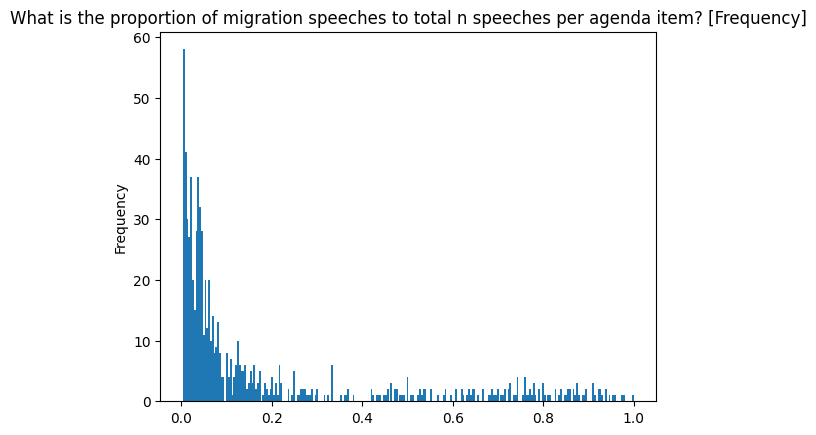

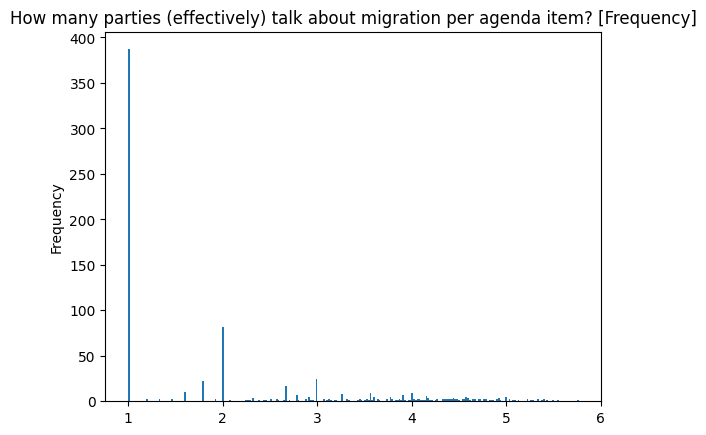

In [203]:
# ignore agenda items with only a few speeches
min_speeches_per_agenda = migration_agendas["n_speeches"].mean() - migration_agendas["n_speeches"].std()

migration_agendas_with_debates = migration_agendas[migration_agendas["n_speeches"] > min_speeches_per_agenda].sort_values("n_speeches")
print("only considering agenda items with >", min_speeches_per_agenda, "speeches:", len(migration_agendas_with_debates), "of", len(migration_agendas))

plt.figure()
migration_agendas_with_debates["proportion_migration_speeches"].plot.hist(bins=250, title="What is the proportion of migration speeches to total n speeches per agenda item? [Frequency]")
plt.figure()
migration_agendas_with_debates["effective_n_parties_migration"].plot.hist(bins=250, title="How many parties (effectively) talk about migration per agenda item? [Frequency]")

Other analyses: 
- agenda setting is not n_speeches_migration == 1 (what if two people from the same party keep setting the agenda) 
=> instead: look at those agenda items, where the party entropy is low => when it is 0: the party is the only party that talks about migration
- but: what if only conservative & right parties talk about migration? => TODO: capure this
- then: is there a yearly trend? => did agenda setting increase over time? did conservative parties start to also join agenda setting?

In [211]:
# Source - https://stackoverflow.com/a
# Posted by Padraic Cunningham, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-25, License - CC BY-SA 3.0

from collections import Counter
from itertools import combinations

def count_pairs(partent_list):
    d  = Counter()
    for sub in partent_list:
        if len(partent_list) > 1: 
            sub = list(sub)
            sub.sort()
            for comb in combinations(sub, 2):
                d[comb] += 1
    return d 

In [243]:
def investigate_agenda_setting(year=None): 
    # effective n parties migration <= 1? 
    # TODO prop effective n parties miration / n parties general should be low? 
    agendas_with_low_n_parties_migration = migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] <= 2]
    
    # only in that year
    if year is not None:
        agendas_with_low_n_parties_migration = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["year"] == year]

    frequency_of_parties = Counter()
    n_agenda_items_with_low = len(agendas_with_low_n_parties_migration)
    agenda_items_per_party = dict() 

    for party in df_final[party_column].unique(): 
        agenda_items_with_that_party = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["parties_migration"].apply(lambda parties: party in parties)]
        frequency_of_parties[party] = len(agenda_items_with_that_party)/n_agenda_items_with_low
        agenda_items_per_party[party] = agenda_items_with_that_party

    team_counts = count_pairs(agendas_with_low_n_parties_migration["parties_migration"])

    return n_agenda_items_with_low, frequency_of_parties, team_counts, agenda_items_per_party

In [261]:
n_items, f_parties, team_counts, agenda_items = investigate_agenda_setting()
print_agendas(agenda_items["green"].index, 5)

17. EU-Egypt strategic and comprehensive partnership and agreements with key third countries (debate)2024-04-232024-04-23
Parties talking about migration: green (1)
[ ] 3: Francisco José Millán Mon (PPE - christian_conservative) [0% migration]
	Mr President, I thank Vice-President Schinas for his very comprehensive presentation. The European Union is going through a very serious situation. In the last two years, Russia's unjustified war against Ukraine has concentrated our efforts, but it cannot make us forget the Southern Neighbourhood. The serious risk of escalation in the Middle East, the difficulties faced by the countries of the Southern Neighbourhood, or the situation in the Sahel are profound challenges that the European Union cannot ignore. We must act. The agreements with Egypt, or the recent ones with Tunisia and Mauritania, are therefore heading in the right direction. Egypt is a very important neighbour, with significant geostrategic weight. The joint declaration of 17 Marc

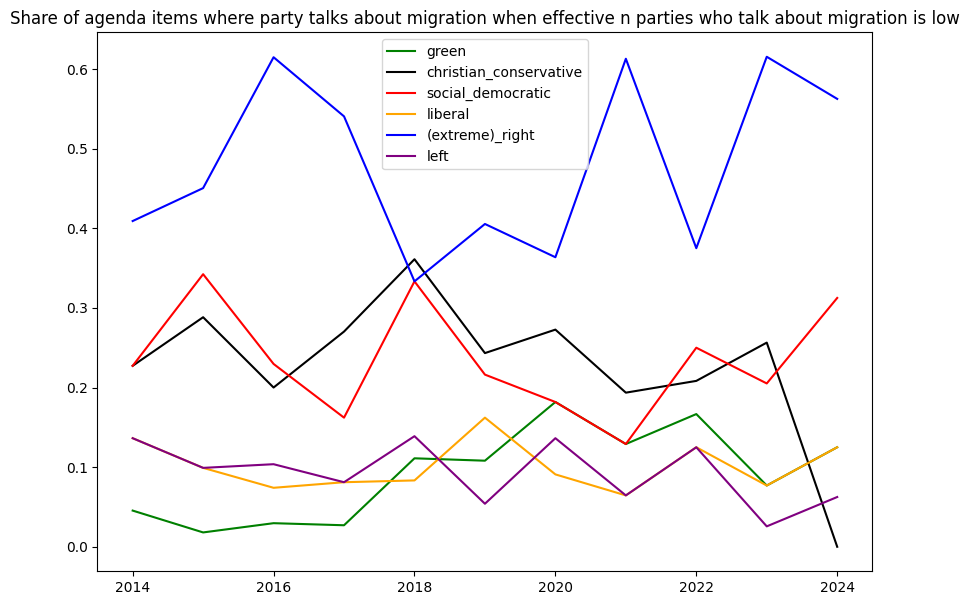

In [247]:
plt.figure(figsize=(10, 7))
plt.title("Share of agenda items where party talks about migration when effective n parties who talk about migration is low")
colormap = json.load(open(f"plotting_parameters/color_maps/color_map_{party_column}.json"))

years = []
n_per_party = {p: [] for p in df_final[party_column].unique()}

for year in df_final["year"].unique():
    years.append(year)

    n_agendas, counts_per_party, counts_per_team, _ = investigate_agenda_setting(year)
    for party, proportion in counts_per_party.items():
        n_per_party[party].append(proportion)

for party in n_per_party.keys(): 
    plt.plot(years, n_per_party[party], label=party, c=colormap[party])
plt.legend()

In [131]:
agenda_items_with_agenda_setting = (migration_agendas_with_debates[migration_agendas_with_debates["party_entropy_migration"] == 0]).index
df_agenda_setting_candidates = df_final[df_final["uq_agenda"].isin(agenda_items_with_agenda_setting)]
print(len(agenda_items_with_agenda_setting),"agenda items with agenda setting")

367 agenda items with agenda setting


Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for what percentage of speeches was the speaking party (block) the only party talking about migration?


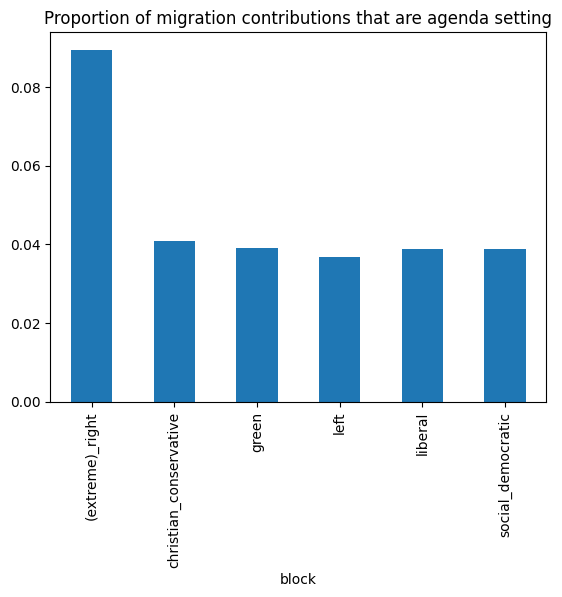

In [136]:
# in the agenda items with agenda setting, which parties are the ones that talk about migration the most? 
n_migrationspeeches_agenda_setting_per_party = df_agenda_setting_candidates[df_agenda_setting_candidates["topic_"+str(final_topic_id)] > final_threshold].groupby("block").size()

# compare this to: in the agenda items with debates (> 6 speeches), how many speeches does each party have? 
speeches_of_agendas_with_debates = df_final[df_final["uq_agenda"].isin(migration_agendas_with_debates.index)]


n_migrationspeeches_per_party = speeches_of_agendas_with_debates[speeches_of_agendas_with_debates["topic_"+str(final_topic_id)] > final_threshold].groupby("block").size()

proportion_agenda_set_speeches = n_migrationspeeches_agenda_setting_per_party / n_migrationspeeches_per_party

proportion_agenda_set_speeches.plot.bar(title="Proportion of migration contributions that are agenda setting")
print("""Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for what percentage of speeches was the speaking party (block) the only party talking about migration?""")


In [252]:
print_agendas(agenda_items_with_agenda_setting, 3)

22. Advance passenger information: enhancing and facilitating external border controls - Advance passenger information: prevention, detection, investigation and prosecution of terrorist offences and serious crime (joint debate - Advance passenger information)2024-04-242024-04-24
Parties talking about migration: liberal (1)
[ ] 2: Jan-Christoph Oetjen (ELDR/ALDE/Renew - liberal) [4% migration]
	Mr President, Commissioner, distinguished colleagues! What is at stake with this advance passenger data? It is about the fact that all of us, when we travel, especially by air, provide data. Data about our name, our date of birth, and similar information, which is then passed on by the airlines to the authorities of the countries we wish to travel to. This is a perfectly normal procedure that exists all over the world. What we are currently discussing here in the European Parliament is: what rules are we actually setting for the processing of this data? Because, distinguished colleagues, for data

In [ ]:
# group by party + how many uq agendas per party (normalized by how many )
df_migration = df_final[df_final["topic_"+str(final_topic_id)] > final_threshold]

n_agendas_per_block_migration = df_migration.groupby("block").agg(n_agendas_migration=pd.NamedAgg("uq_agenda", lambda agendas: len(set(agendas))))
n_agendas_per_block_all = df_final.groupby("block").agg(n_agendas_all=pd.NamedAgg("uq_agenda", lambda agendas: len(set(agendas))))

n_agendas_per_block = n_agendas_per_block_migration.join(n_agendas_per_block_all)
n_agendas_per_block["proportion_migration"] = n_agendas_per_block["n_agendas_migration"] / n_agendas_per_block["n_agendas_all"] 

In [106]:
n_agendas_per_block.sort_values("proportion_migration", ascending=False)

,n_agendas_migration,n_agendas_all,proportion_migration
block,,,
(extreme)_right,540,5746,0.093978
social_democratic,391,5700,0.068596
christian_conservative,388,6032,0.064324
left,272,4958,0.054861
liberal,246,5018,0.049024
green,187,4655,0.040172
